# Conv1D - Time Serise Dataset

* 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
* https://data.kma.go.kr/cmmn/main.do
* 기후통계분석 -> 기온분석 -> 기간(20110101~20191231) -> 검색 -> CSV 다운로드
* Seoul_Temp.csv

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Import Packages

* Packages

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# I. Colab File Upload

> ## 1) 'Seoul_Temp.csv' 파일을 Colab에 업로드 후 진행

In [ ]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [ ]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


# II. Data Preprocessing

> ## 1) 일일 평균온도('avg') 변화 시각화

* 일일 평균온도 변화에 일정한 패턴 확인

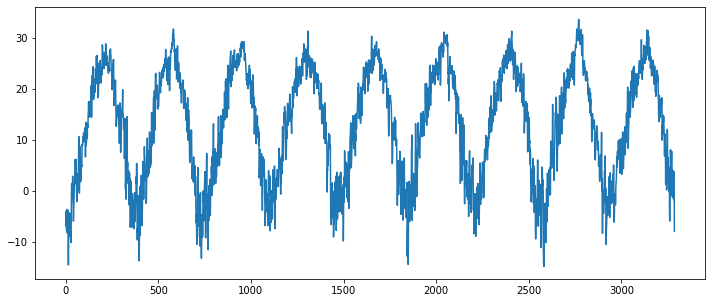

In [ ]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

* tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

> ## 3) Train vs. Test Split

* Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
* Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일

In [ ]:
train = temp_data[0:2557]
test  = temp_data[2557:]

# III. 시계열 데이터 처리 함수

> ## 1) 시계열 학습용 데이터 생성 함수 정의

* X : 학습 평균온도 데이터
* y : 정답 평균온도 데이터
* 일정 기간의 X로 y를 예측하도록 학습

In [ ]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

> ## 2) loop_back 기간 설정 후 학습데이터 생성

* 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [ ]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

> ## 3) Tensor Reshape

In [ ]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

# IV. Conv1D Modeling

> ## 1) Model Define

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

model = Sequential(name = 'Conv1D')

model.add(Conv1D(32, 3, activation = 'relu', input_shape = (180, 1)))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation = 'relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, activation = 'relu'))
model.add(MaxPooling1D(3))

model.add(Flatten())
model.add(Dense(1, activation = 'tanh'))

* Model Summary

In [ ]:
model.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 178, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 59, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 57, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 17, 64)            12352     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 64)            0    

> ## 2) Model Compile

In [ ]:
model.compile(loss = 'mse',
              optimizer = 'rmsprop',
              metrics = ['mae'])

> ## 3) Model Fit

* 약 4분

In [ ]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200, 
                 batch_size = 16,  
                 validation_data = (test_X, test_y))

Epoch 1/200
149/149 [==============================] - 16s 12ms/step - loss: 0.0245 - mae: 0.1174 - val_loss: 0.0279 - val_mae: 0.1314
Epoch 2/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0183 - mae: 0.1039 - val_loss: 0.0264 - val_mae: 0.1293
Epoch 3/200
149/149 [==============================] - 1s 5ms/step - loss: 0.0175 - mae: 0.1015 - val_loss: 0.0218 - val_mae: 0.1186
Epoch 4/200
149/149 [==============================] - 1s 6ms/step - loss: 0.0171 - mae: 0.1008 - val_loss: 0.0218 - val_mae: 0.1189
Epoch 5/200
149/149 [==============================] - 1s 6ms/step - loss: 0.0164 - mae: 0.0982 - val_loss: 0.0260 - val_mae: 0.1285
Epoch 6/200
149/149 [==============================] - 1s 5ms/step - loss: 0.0161 - mae: 0.0980 - val_loss: 0.0254 - val_mae: 0.1272
Epoch 7/200
149/149 [==============================] - 1s 6ms/step - loss: 0.0154 - mae: 0.0952 - val_loss: 0.0231 - val_mae: 0.1217
Epoch 8/200
149/149 [==============================] - 1s 6ms/step 

> ## 4) 학습결과 시각화

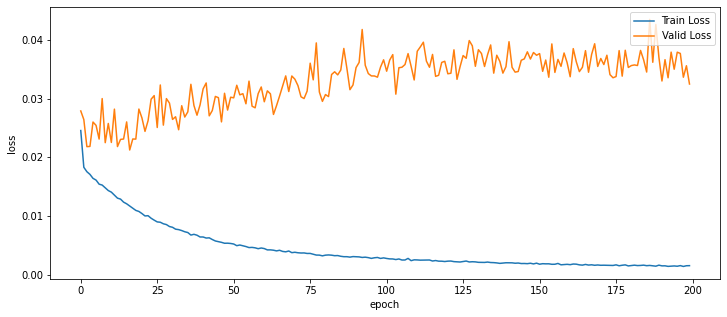

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaluate

In [ ]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  [0.0013629912864416838, 0.029376061633229256]
Test Score:  [0.03247177600860596, 0.14352281391620636]


# V. Model Predict

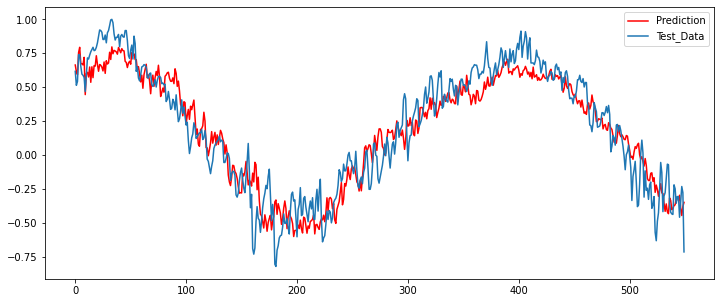

In [ ]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
    
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# 
# 
# 
# The End
# 
# 
# 